## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

# Описание проекта
В проекте нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году.
В колонках датасета содержатся следующие данные:
* longitude — широта;
* latitude — долгота;
* housing_median_age — медианный возраст домов в жилом массиве;
* total_rooms — общее количество комнат в домах жилого массива;
* total_bedrooms — общее количество спален в домах жилого массива;
* population — количество человек, которые проживают в жилом массиве;
* households — количество домовладений в жилом массиве;
* median_income — медианный доход жителей жилого массива;
* median_house_value — медианная стоимость дома в жилом массиве;
* ocean_proximity — близость к океану.

На основе данных нужно предсказать медианную стоимость дома в жилом массиве — median_house_value. Для оценки качества модели используются метрики: RMSE, MAE и R2.

## Подготовка данных

### Подключение библиотек, инициализация Spark-сессии

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

RANDOM_SEED = 42
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California Housing") \
                    .getOrCreate()

### Загрузка данных

In [3]:
df_housing = spark.read.load('/datasets/housing.csv',
                                        format='csv',
                                             sep=',',
                                    inferSchema=True,
                                         header=True)

#вывод схемы датафрейма
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



**Вывод типов данных колонок и их названий**

In [4]:
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


### Анализ данных

**Вывод первых пяти строк**

In [5]:
pd.DataFrame(df_housing.take(5), columns=df_housing.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


**Просмотрим значения, содержащиеся в категориальной переменной**

In [6]:
df_housing.groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,ISLAND,5
1,NEAR OCEAN,2658
2,NEAR BAY,2290
3,<1H OCEAN,9136
4,INLAND,6551


Интересно, что всего пять жилых массивов, которые находятся на острове.

**Посмотрим базовые описательные статистики с помощью `describe()`** 

Также добавим квантили

In [7]:
num_columns = [c for c in df_housing.columns if c != 'ocean_proximity']

quantile_lst = df_housing.approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)
print(quantile_lst)

[[-121.8, -118.49, -118.01], [33.93, 34.26, 37.71], [18.0, 29.0, 37.0], [1447.0, 2127.0, 3148.0], [296.0, 435.0, 647.0], [787.0, 1166.0, 1725.0], [280.0, 409.0, 605.0], [2.5625, 3.5347, 4.7431], [119600.0, 179700.0, 264700.0]]


Соберем значения в таблицу

In [8]:
quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])
quantile_df.index = num_columns

df_housing_describe = df_housing.select(*num_columns).describe().toPandas().set_index('summary').T.join(quantile_df)
columns_order_to_describe = ['count', 'mean', 'stddev','min', 'quantile_25', 'quantile_50', 'quantile_75', 'max']

display(df_housing_describe[columns_order_to_describe])

,count,mean,stddev,min,quantile_25,quantile_50,quantile_75,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-121.800,-118.490,-118.010,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,33.930,34.260,37.710,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,18.000,29.000,37.000,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,1447.000,2127.000,3148.000,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,296.000,435.000,647.000,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,787.000,1166.000,1725.000,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,280.000,409.000,605.000,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,2.562,3.535,4.743,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,119600.000,179700.000,264700.000,500001.0


**Проверим наличие пропусков в датасете**

In [9]:
nan_table = \
df_housing.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_housing.columns]
    ).toPandas().T.rename(columns={0:'NA'})

nan_table['NA_percents'] = nan_table['NA'] / df_housing.count() * 100

display(nan_table)

,NA,NA_percents
longitude,0,0.000
latitude,0,0.000
housing_median_age,0,0.000
total_rooms,0,0.000
total_bedrooms,207,1.003
population,0,0.000
households,0,0.000
median_income,0,0.000
median_house_value,0,0.000
ocean_proximity,0,0.000


Пропуски есть в колонке `total_bedrooms`. Так как по условиям задачи необходимо использовать линейную регрессию, то пропуски следует заполнить.

Из таблицы видно, что пропусков всего один процент. Посмотрим статистику по этим строкам.

Распределение по категориальному признаку

In [10]:
df_housing.filter('total_bedrooms is NULL').groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,NEAR OCEAN,30
1,NEAR BAY,20
2,<1H OCEAN,102
3,INLAND,55


Базовые статистики

In [11]:
quantile_lst = df_housing.filter('total_bedrooms is NULL').approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)
quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])
quantile_df.index = num_columns

df_housing_describe_nans = df_housing.filter('total_bedrooms is NULL').select(*num_columns).describe().toPandas().set_index('summary').T.join(quantile_df)

display(df_housing_describe_nans[columns_order_to_describe])

,count,mean,stddev,min,quantile_25,quantile_50,quantile_75,max
longitude,207,-119.47256038647346,2.001423938482286,-124.13,-121.850,-118.490,-117.980,-114.59
latitude,207,35.49763285024152,2.097297776100012,32.66,33.960,34.200,37.510,40.92
housing_median_age,207,29.270531400966185,11.964926543525893,4.0,19.000,30.000,38.000,52.0
total_rooms,207,2562.6038647342993,1787.269788987037,154.0,1307.000,2155.000,3473.000,11709.0
total_bedrooms,0,None,None,None,NaN,NaN,NaN,None
population,207,1477.7729468599034,1057.4482115173646,37.0,781.000,1217.000,1891.000,7604.0
households,207,510.02415458937196,386.1207044990592,16.0,257.000,427.000,629.000,3589.0
median_income,207,3.8222439613526573,1.9555946874300458,0.8527,2.562,3.412,4.633,15.0001
median_house_value,207,206007.28019323671,111638.21454491059,45800.0,128100.000,175000.000,269300.000,500001.0


Какой-то закономерности в пропусках выявить не удалось. Так как пропусков всего один процент, то заполним такие значения медианным значением признака.

Получим медианное значение и выведем его на экран

In [12]:
total_bedrooms_median = df_housing.approxQuantile('total_bedrooms', [0.5], 0)[0]

total_bedrooms_median

435.0

**Заполним пропущенные значения**

In [13]:
df_housing = df_housing.fillna(total_bedrooms_median, subset=['total_bedrooms'])
df_housing.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_housing.columns]
    ).toPandas().T.rename(columns={0:'NA'})

,NA
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


Пропуски заполнены

Рассмотрим также корреляцию признаков, исключив целевой и категориальный признаки.

Для этого будем использовать функцию корреляции в пакете `pyspark.ml.stat`. Между тем, требуется требуется перевести типы данных в столбцах в `Vector`, для конвертации данных будем использовать `VectorAssembler`, а затем применим корреляцию.

22/03/28 20:46:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/03/28 20:46:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<AxesSubplot:>

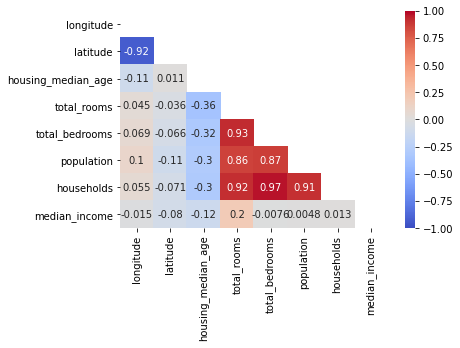

In [14]:
#выделим признаки
corr_columns = [c for c in num_columns if c != 'median_house_value']

#преобразуем данные в `Vector`
vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
df_vector = assembler.setHandleInvalid("skip").transform(df_housing[corr_columns]).select(vector_col)

#создаем матрицу
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()


matrix_df = pd.DataFrame(cor_np, columns=corr_columns)
matrix_df.index = corr_columns

#делаем "уголок" и выводим график корреляции в виде heatmap
matrix_mask = np.triu(matrix_df)
sns.heatmap(matrix_df,
           annot=True,
     mask=matrix_mask,
              vmin=-1,
               vmax=1,
      cmap='coolwarm')

**Вывод:**
* Среди жилых массивов есть такие, где всего лишь один дом;
* Есть жилые массивы, где всего 3 человека проживает;
* В столбце `total_bedrooms` есть пропуски, которые стоит заполнить;

В данных есть выбросы. Если при обучении модели наличие выбросов будет мешать, то от них стоит избавиться.

Коррелируют между собой: кол-во спален, кол-во комнат, кол-во человек в жилом массиве, кол-во домовладений.

## Обучение моделей

### Подготовка

Разделим признаки по типу

In [15]:
cat_features = 'ocean_proximity'
num_features = [c for c in num_columns if c != 'median_house_value']
target = 'median_house_value'

#### Трансформация категориальных признаков

Трансформируем категориальные признаки с помощью `StringIndexer`

In [16]:
indexer = StringIndexer(inputCol=cat_features,
                        outputCol=cat_features+'_idx')
df_housing = indexer.fit(df_housing).transform(df_housing)

In [17]:
cols = [c for c in df_housing.columns if c.startswith(cat_features)]
df_housing.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
+---------------+-------------------+
only showing top 3 rows



 Дополнительно применим OHE-кодирование

In [18]:
encoder = OneHotEncoder(inputCol='ocean_proximity_idx',
                        outputCol=cat_features+'_ohe')
df_housing = encoder.fit(df_housing).transform(df_housing)

In [19]:
cols = [c for c in df_housing.columns if c.startswith(cat_features)]
df_housing.select(cols).show(3)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



В конце преобразуем этот признак в один вектор.

In [20]:
categorical_assembler = \
    VectorAssembler(inputCols=['ocean_proximity_ohe'],
                    outputCol='categorical_features')
df_housing = categorical_assembler.transform(df_housing)

In [21]:
pd.DataFrame(df_housing.take(3),
             columns=df_housing.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"


#### Трансформация числовых признаков

Для числовых признаков применим шкалирование значений, чтобы сильные выбросы не смещали предсказания модели

In [22]:
numerical_assembler = VectorAssembler(inputCols=num_features,
                                      outputCol='numerical_features')
df_housing = numerical_assembler.transform(df_housing)

standard_scaler = StandardScaler(inputCol='numerical_features',
                                 outputCol='numerical_features_scaled')
df_housing = standard_scaler.fit(df_housing).transform(df_housing)

После всех трансформаций получаем такие признаки:

In [23]:
df_housing.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector'),
 ('numerical_features', 'vector'),
 ('numerical_features_scaled', 'vector')]

#### Преобразование категориальных и численных признаков в один вектор

In [24]:
all_features = ['categorical_features', 'numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features,
                                  outputCol='all_features')

df_housing = final_assembler.transform(df_housing)

df_housing.select('all_features').show(3)

+--------------------+
|        all_features|
+--------------------+
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
+--------------------+
only showing top 3 rows



#### Разделение на выборки

Разделим датасет на две части - выборку для обучения и выборку для тестирования качества

In [25]:
train, test = df_housing.select(['all_features',
                                 'numerical_features_scaled',
                                 'median_house_value']).randomSplit([.75, .25], seed=RANDOM_SEED)
print(f'Обучающая выборка: {train.count()} строк, {len(train.columns)} столбцов',
      f'\nТестовая выборка:, {test.count()} строк, {len(test.columns)} столбцов')

Обучающая выборка: 15500 строк, 3 столбцов 
Тестовая выборка:, 5140 строк, 3 столбцов


### Обучение моделей

По условиям задачи необходимо сравнить метрики RMSE, MAE, R2 на следующих вариациях датасета:
* со всеми признаками;
* без категориального признака.

В первом случае для обучения будем использовать вектор `all_features`, а во втором - `numerical_features_scaled`. Все полученные данные сохраним в список

In [26]:
# Создаем список, куда будем вносить результаты
data_table = [
    ['features_used', 'RMSE', 'MAE', 'R2']
]

# Перебираем варианты используемых признаков
for col in ['all_features', 'numerical_features_scaled']:
    # обучаем модель
    lr = LinearRegression(featuresCol=col, labelCol=target)
    model = lr.fit(train)
    
    #запишем предсказания на тестовой выборке
    predictions = model.transform(test)
    
    #выделим предсказания и ответы в отдельную переменную
    results = predictions.select(['prediction', target])
    
    #соберем все в RDD
    results_collect = results.collect()
    results_list = [ (float(i[0]), float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
    
    #запишем метрики в отдельную переменную
    metrics = RegressionMetrics(scoreAndLabels)
    
    #добавим результаты в список
    data_table.append([col,
                       metrics.rootMeanSquaredError,
                       metrics.meanAbsoluteError,
                       metrics.r2])

22/03/28 20:46:13 WARN Instrumentation: [6f1ea083] regParam is zero, which might cause numerical instability and overfitting.
22/03/28 20:46:15 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/03/28 20:46:15 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/03/28 20:46:23 WARN Instrumentation: [c1cabafb] regParam is zero, which might cause numerical instability and overfitting.


# Анализ результатов

In [27]:
pd.DataFrame(data_table[1:], columns=data_table[0])

,features_used,RMSE,MAE,R2
0,all_features,67559.131,49365.353,0.660
1,numerical_features_scaled,68462.761,50316.784,0.651


Исходя из полученных результатов, можно сказать, что модель обучается лучше на всех признаках без исключения.